In [1]:
import numpy as np
import pandas as pd
from scipy.fftpack import dct, idct
from sklearn.decomposition import PCA

import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
matplotlib.style.use('styles.mplstyle')

import sys
sys.path.append('../')
from helpers import cm2inch, title

In [2]:
def load_contours(fn, num_samples=100):
    df = pd.read_csv(fn)
    return df[[str(i) for i in range(num_samples)]].values

# contours = load_contours('../data/phrase-contours/boehme-phrase-contours.csv')

In [3]:
def dct_mse(contours, dim):
    N = contours.shape[1]
    coeff = dct(contours, norm='ortho')
    coeff[:, dim+1:] = 0
    reconstruction = idct(coeff, norm='ortho', n=N)
    return np.mean((contours - reconstruction) ** 2)

def dct_mses(contours, dims):
    return np.array([dct_mse(contours, d) for d in dims])

In [4]:
def pca_mse(contours, pca, dim):
    coeff = pca.transform(contours)
    coeff[:, dim+1:] = 0
    reconstruction = pca.inverse_transform(coeff)
    return np.mean((contours - reconstruction) ** 2)

def pca_mses(contours, pca, dims):
    return np.array([pca_mse(contours, pca, d) for d in dims])

# pca_loss(X_de, pca_de, 5)

In [5]:
datasets = {
    'motifs': load_contours('../data/motif-contours/responsory-subset-syllables.csv')[:5000, :],
    'phrases': load_contours('../data/phrase-contours/liber-responsories-phrase-contours.csv'),
    'songs': load_contours('../data/song-contours/gregobase.csv')
}

In [6]:
pcas = {}
for name, contours in datasets.items():
    pcas[name] = PCA(n_components=100, svd_solver='full')
    pcas[name].fit(contours)

## Subplots

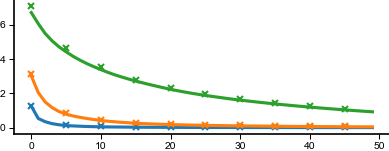

In [7]:
def show_mse(datasets, pcas, skip=5, ds=np.arange(100), **kwargs):
    for name, contours in datasets.items():
        l, = plt.plot(ds, pca_mses(contours, pcas[name], ds), **kwargs)
        plt.plot(ds[::skip], dct_mses(contours, ds)[ds][::skip], 'x', c=l.get_color(), **kwargs)
        
plt.figure(figsize=cm2inch(8.2, 3))
show_mse(datasets, pcas, ds=np.arange(50))

No handles with labels found to put in legend.


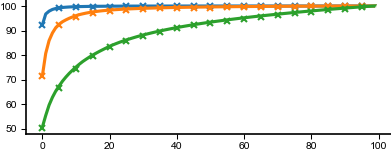

In [8]:
def show_explained_variance(datasets, pcas, skip=5, ds=np.arange(100), **kwargs):
    for name, contours in datasets.items():
        pca_var = np.var(pcas[name].transform(contours), axis=0)
        dct_var = np.var(dct(contours, norm='ortho'), axis=0)

        pca_ratio = pca_var / pca_var.sum() * 100
        dct_ratio = dct_var / dct_var.sum() * 100

        l, = plt.plot(ds, np.cumsum(pca_ratio)[ds], **kwargs)
        plt.plot(ds[::skip], np.cumsum(dct_ratio)[ds][::skip], 'x', c=l.get_color(), **kwargs)
        
        
plt.figure(figsize=cm2inch(8, 3))
show_explained_variance(datasets, pcas)
plt.legend()

## Combined plot

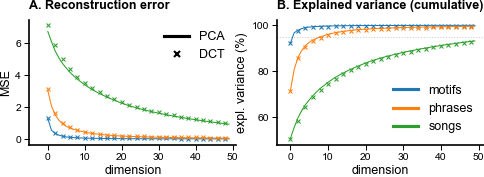

In [9]:
plt.figure(figsize=cm2inch(8.2, 3))

ds = np.arange(0, 50)

plt.subplot(121)
kwargs = dict(ms=2, lw=.5, markeredgewidth=.5)
show_mse(datasets, pcas, ds=ds, skip=2, **kwargs)
title('A. Reconstruction error')
plt.ylabel('MSE')
plt.xlabel('dimension')

plt.plot(-10, 0, '-', c='k', label='PCA')
plt.plot(-10, 0, 'x', c='k', label='DCT')
plt.xlim(-5, 51)
plt.legend()

plt.subplot(122)
show_explained_variance(datasets, pcas, ds=ds, skip=2, **kwargs)
plt.axhline(95, 0, 51, c='k', ls=':', alpha=.2, lw=.5)
plt.ylabel('expl. variance (%)')
title('B. Explained variance (cumulative)')
plt.xlabel('dimension')

plt.plot(-1, 100, c='C0', label='motifs')
plt.plot(-1, 100, c='C1', label='phrases')
plt.plot(-1, 100, c='C2', label='songs')
leg = plt.legend()

plt.tight_layout(pad=0)
plt.savefig('../figures/fig03/fig03-evaluation.pdf')

In [10]:
alpha=.95

for name, contours in datasets.items():
    pca_var = np.var(pcas[name].transform(contours), axis=0)
    dct_var = np.var(dct(contours, norm='ortho'), axis=0)
    pca_ratio = pca_var / pca_var.sum()
    dct_ratio = dct_var / dct_var.sum()

    pca_idx = np.where(np.cumsum(pca_ratio) > alpha)[0][0]
    dct_idx = np.where(np.cumsum(dct_ratio) > alpha)[0][0]
    print('PCA:', name, pca_idx, 100*np.cumsum(pca_ratio)[pca_idx].round(5))
    print('DCT:', name, dct_idx, 100*np.cumsum(dct_ratio)[pca_idx].round(5))

PCA: motifs 1 96.732
DCT: motifs 1 96.538
PCA: phrases 8 95.003
DCT: phrases 9 94.691
PCA: songs 59 95.03
DCT: songs 61 94.744
